In [94]:
import palantir
import scanpy as sc
import numpy as np
import pandas as pd
import os
from scipy import sparse
from scipy.ndimage.filters import gaussian_filter
from matplotlib.patches import Patch
import pickle
import matplotlib as mpl

# Plotting 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Inline plotting
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Reset random seed
np.random.seed(5)
import random
from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess
#os.environ['R_HOME'] = '/path/to/R'

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score as sil_score
from scipy.cluster import hierarchy
from scipy.spatial import distance
from scipy.cluster.hierarchy import ward, fcluster
from sklearn.decomposition import PCA
import random
random.seed(10)

from scipy.stats import zscore
import colorcet as cc
from matplotlib.colors import ListedColormap

/tmp/ipykernel_63830/225376741.py:7: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [95]:
sc.settings.set_figure_params(dpi=80,dpi_save=300,facecolor='white',format='svg')

In [96]:
ep_ad = sc.read_h5ad('./epithelial_l_ad.h5ad')
pr_res = pickle.load(open('./pr_res.pickle','rb'))

In [97]:
ep_ad.obs['pseudotime'] = pr_res.pseudotime
ep_ad.obs['entropy'] = pr_res.entropy

In [98]:
magic_data = np.load('./palantir_magic_imputed_data.npy')

In [99]:
ep_ad.layers['MAGIC_imputed_data'] = magic_data

In [100]:
tf_d = {
    'Adeno_TFs':['Hif1a','Fosb','Nfkb1','Irf6','Hes1','Maff','Jun','Runx1','Atf3','Elf1','Myc','Egr1','Zbtb7a','Sox9','Ikzf2','Klf2','Plscr1'],
    'Transition_TFs':['Grhl3','Barx2','Stat1','Irf7','Tfcp2l1','Znfx1','Mxd1','Ltf','Hnf4a','Irf1','Casz1','Elf3','Stat2','Xbp1','Sox4','Onecut2'],
    'NEPC_TFs':['Stat3','Sox2','Sox1','Foxa2','Tox','Prox1','Hoxa10','Tcf4','Ybx1','Insm1','Hoxa9','Ascl1','Hes6','Smarcc1','Pou2f2','Gata3']
}
tf_gene_list = []
for key in tf_d.keys():
    tf_gene_list.append(tf_d[key])
tf_gene_list = [item for sublist in tf_gene_list for item in sublist]
tf_gene_list = tf_gene_list+['Ar']

/home/tnoel/anaconda3/envs/myenv_39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/tnoel/anaconda3/envs/myenv_39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


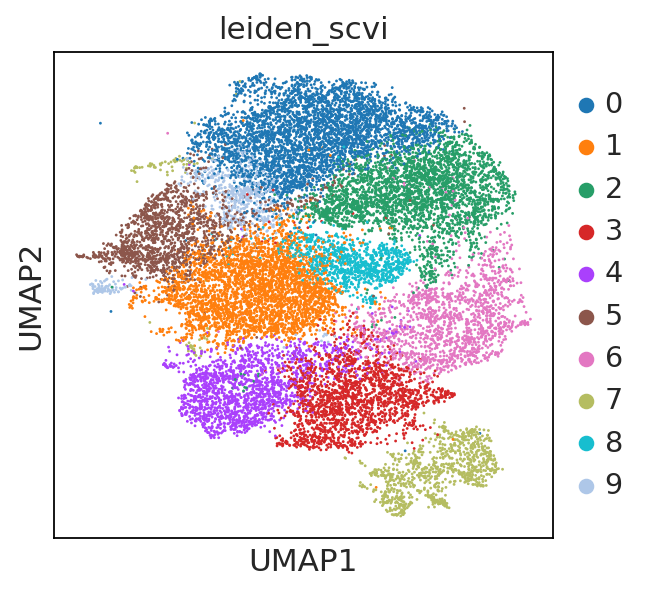

In [101]:
sc.pl.umap(ep_ad,color='leiden_scvi')

/home/tnoel/anaconda3/envs/myenv_39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/tnoel/anaconda3/envs/myenv_39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


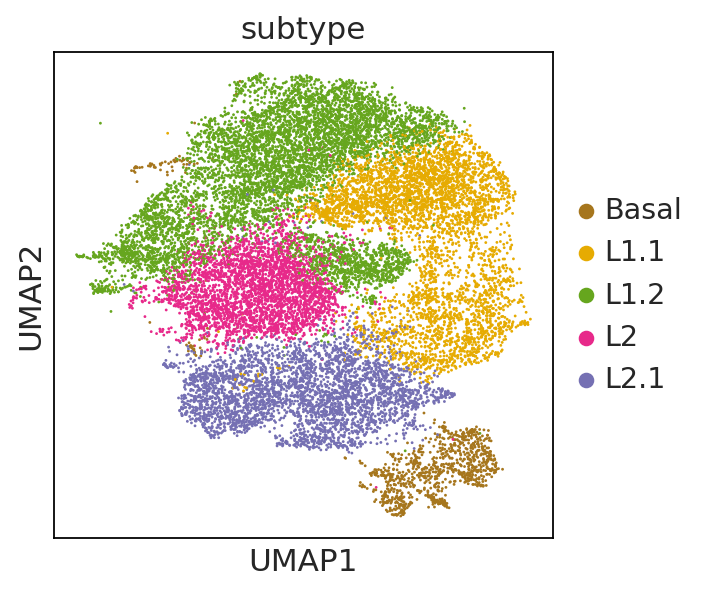

In [102]:
sc.pl.umap(ep_ad,color='subtype',palette=sns.color_palette('Dark2_r'))

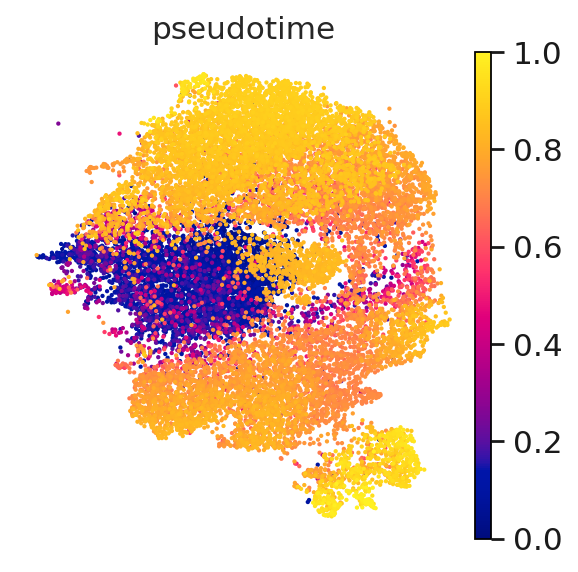

In [103]:
sc.pl.umap(ep_ad,color='pseudotime',cmap=ListedColormap(sns.color_palette(cc.bmy).as_hex()),size=15,frameon=False)

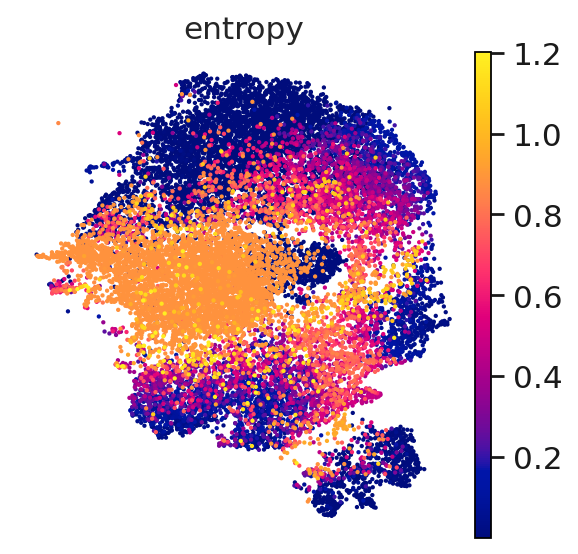

In [104]:
sc.pl.umap(ep_ad,color='entropy',cmap=ListedColormap(sns.color_palette(cc.bmy).as_hex()),size=15,frameon=False)

In [105]:
# get "MAGIC_imputed_data" from palantir for transcription factors of interest, 
# genes filtered if on low end of number of cells expressed in and total expression,
# cells ordered by palantir pseudotime
def get_imputed_tf_df(tf_gene_list):
    imputed_X = pd.DataFrame(ep_ad.layers['MAGIC_imputed_data'])
    #imputed_X = pd.DataFrame(ep_norm_ad.X.toarray())
    imputed_X.columns = ep_ad.var_names
    imputed_X.index = ep_ad.obs_names
    imputed_tf = imputed_X[tf_gene_list].copy()
    imputed_tf['pseudotime'] = pr_res.pseudotime
    imputed_tf = imputed_tf.sort_values(by='pseudotime',ascending=True)
    
    min_tot = np.percentile(imputed_tf.drop(columns={'pseudotime'}).sum(axis=0),5)
    min_bool = np.percentile(imputed_tf.drop(columns={'pseudotime'}).astype(bool).astype(int).sum(axis=0),5)
    tots=pd.DataFrame(imputed_tf.drop(columns={'pseudotime'}).sum(axis=0))
    bools=pd.DataFrame(imputed_tf.drop(columns={'pseudotime'}).astype(bool).astype(int).sum(axis=0))
    filtered_genes1 = tots[tots[0]>min_tot].index.tolist()
    filtered_genes2 = bools[bools[0]>min_bool].index.tolist()
    filtered_genes = np.unique(filtered_genes1+filtered_genes2).tolist()

    imputed_tf = imputed_tf[filtered_genes+['pseudotime']]
    
    return imputed_tf

# smooth tf gene expression
def get_smoothed_tf_df(imputed_tf,n_convolve):
    smooth_df = imputed_tf.drop(columns={'pseudotime'})
    weights = np.ones(n_convolve) / n_convolve
    for gene in smooth_df.columns:
        smooth_df[gene] = np.convolve(smooth_df[gene].values, weights, mode="same")
    
    return smooth_df

In [106]:
n_convolve = 500
imputed_tf = get_imputed_tf_df(tf_gene_list)
smooth_df = get_smoothed_tf_df(imputed_tf,n_convolve)

In [107]:
genes=pd.DataFrame(imputed_tf.drop(columns={'pseudotime'}).columns).rename(columns={'gene_name':'gene'})
grps = []
for gene in genes['gene']:
    if gene in ['Ar']:
        key = gene
        grps.append(key)
    for key in tf_d.keys():
        if gene in tf_d[key]:
            grps.append(key)
genes['TF_grp'] = grps
genes.index = genes['gene']
grps = genes['TF_grp']

#### summarize tfs into modules

In [109]:
X = np.array(smooth_df.T)
z = zscore(X,axis=1)

k=3
dist_metric='euclidean'
linkages='ward'
agg_clustering = AgglomerativeClustering(n_clusters=k,affinity = dist_metric,linkage=linkages).fit(z)
labels = agg_clustering.labels_

relabel_d = {
    0:1,
    1:0,
    2:2,
}
labels = [relabel_d[x] for x in labels]

/home/tnoel/anaconda3/envs/myenv_39/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


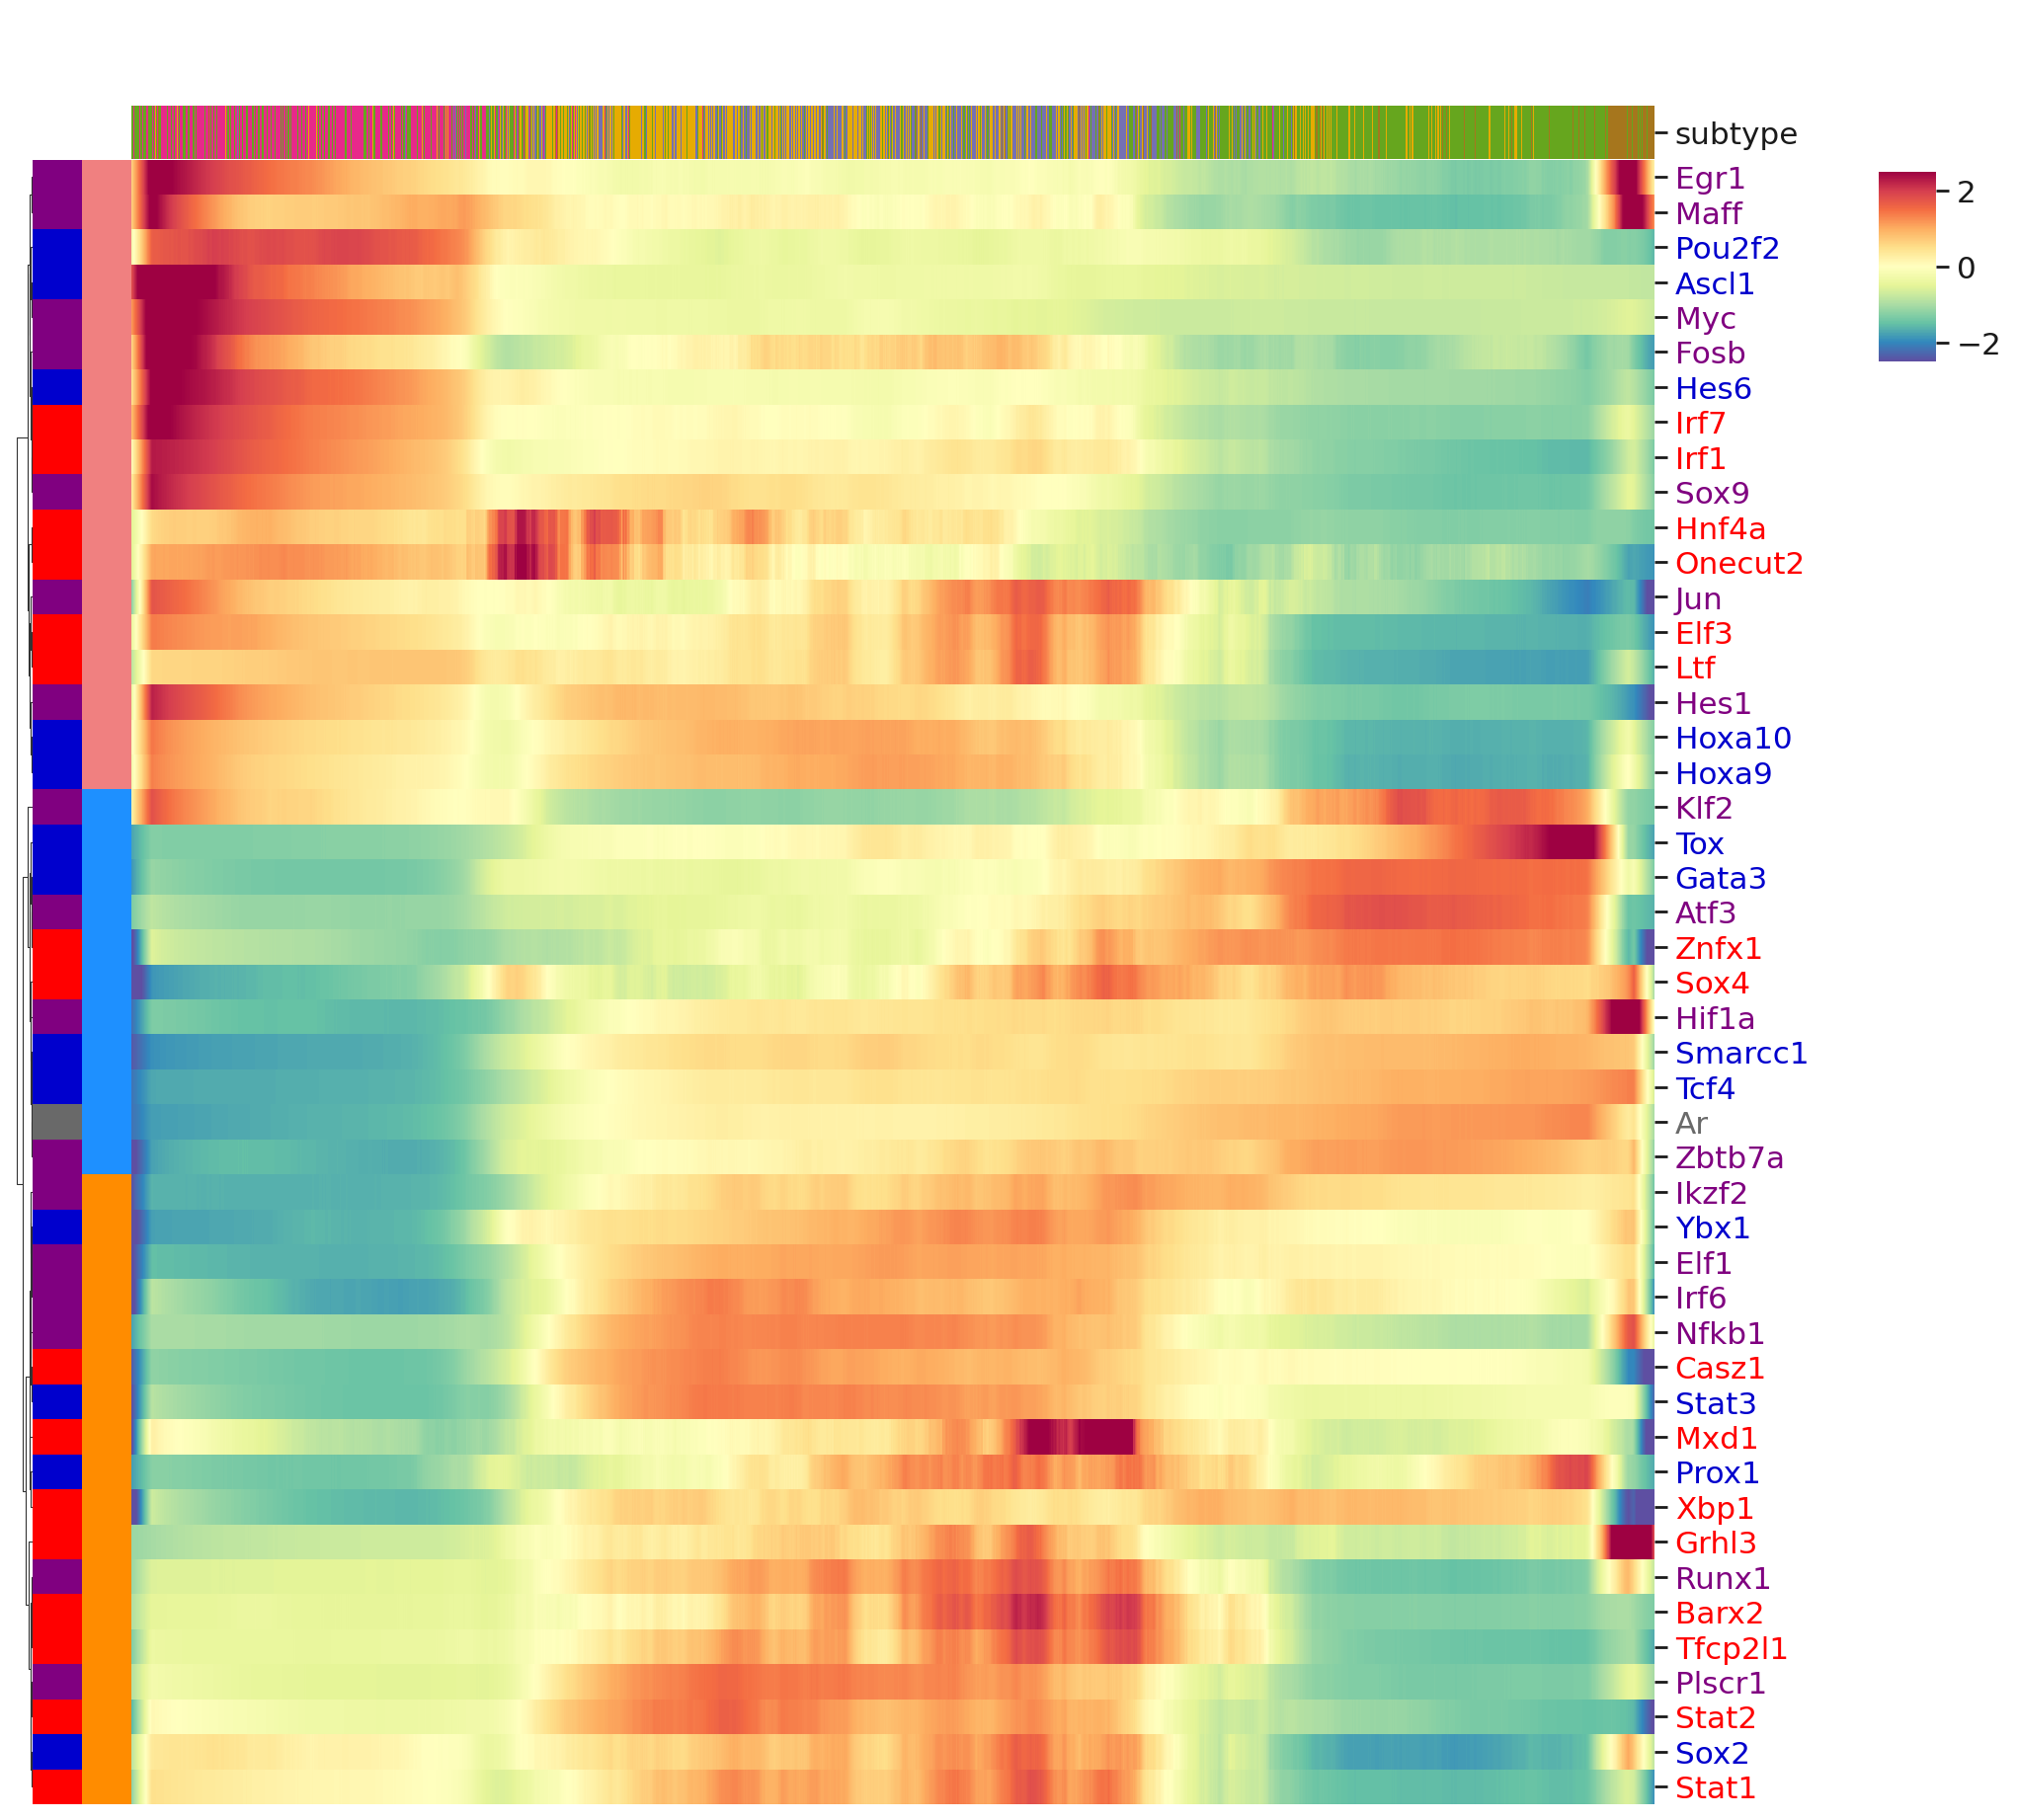

In [110]:
tf_modules = pd.DataFrame(np.vstack([smooth_df.T.index,labels]).T,columns=['tf','module']).set_index('tf')
tf_modules = tf_modules['module']

row_colormap = {
    'Adeno_TFs':'purple',
    'Transition_TFs':'red',
    'NEPC_TFs':'mediumblue',
    'Ar':'dimgrey'
}
row_colors = grps.map(row_colormap)

col_colormap = {}
clusters = ep_ad.obs['subtype']
for i,cluster in enumerate(np.unique(clusters)):
    col_colormap[cluster] = sns.color_palette('Dark2_r').as_hex()[i]
col_colors = clusters.map(col_colormap)

row_colormap2 = {
    0:'lightcoral',
    1:'darkorange',
    2:'dodgerblue',
}
row_colors2 = tf_modules.map(row_colormap2)

#plt.rcParams['svg.fonttype'] = 'none'
g=sns.clustermap(smooth_df.T,col_cluster=False,row_cluster=True,metric='euclidean',method='ward',vmax=2.5,vmin=-2.5,z_score=0,
               dendrogram_ratio=(.01,.05),figsize=(12,12),yticklabels=True,cmap='Spectral_r',col_colors=col_colors,row_colors=[row_colors,row_colors2],xticklabels=False)
ax = g.ax_heatmap
g.ax_cbar.set_position((1., .8, .03, .1))
ax.set_xlabel('')
ax.set_ylabel('')

for tick_label in g.ax_heatmap.axes.get_yticklabels():
    tick_text = tick_label.get_text()
    gene_name = grps.loc[tick_text]
    tick_label.set_color(row_colormap[gene_name])
plt.show()

In [111]:
tf_modules_df=pd.DataFrame(tf_modules).reset_index().rename(columns={0:'module'})

tf_grps = []
for tf in tf_modules_df['tf'].tolist():
    for key in tf_d.keys():
        if tf in tf_d[key]:
            tf_grps.append(key)
    if tf == 'Ar':
        tf_grps.append(np.nan)
tf_modules_df['tf_grp'] = tf_grps

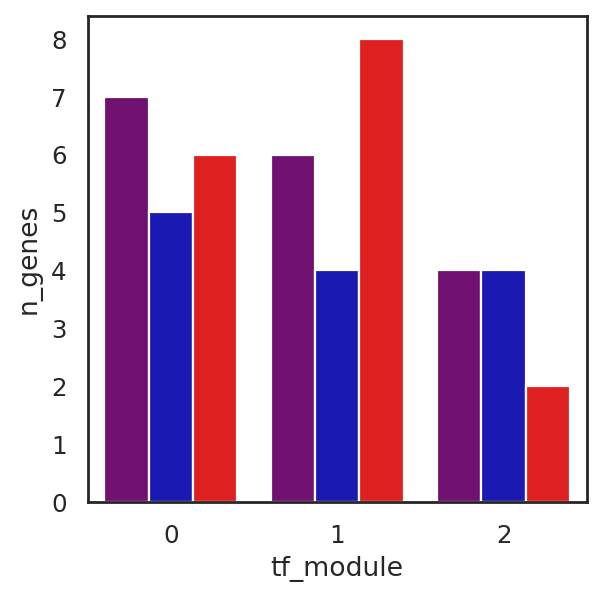

In [113]:
colormap = {
    'Adeno_TFs':'purple',
    'Transition_TFs':'red',
    'NEPC_TFs':'mediumblue'
}

df = tf_modules_df.groupby(['module','tf_grp']).size().reset_index().rename(columns={0:'n_genes','module':'tf_module'})
plt.rcParams['svg.fonttype']='none'
sns.set_theme(style='white')
g=sns.barplot(df,x='tf_module',hue='tf_grp',y='n_genes',palette=colormap)
g.legend_.remove()

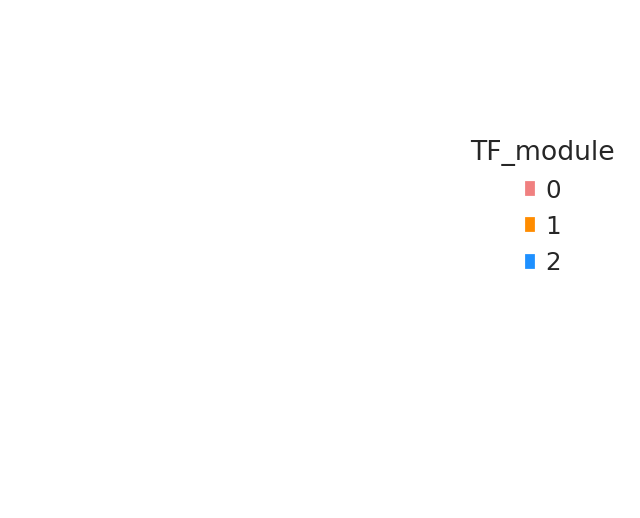

In [114]:
plt.rcParams['svg.fonttype']='none'
handles = [Patch(facecolor=row_colormap2[name]) for name in row_colormap2]
legend=plt.legend(handles, row_colormap2, title='TF_module',frameon=False,
           bbox_to_anchor=(1.15, .75), bbox_transform=plt.gcf().transFigure)
plt.axis('off')
plt.show()

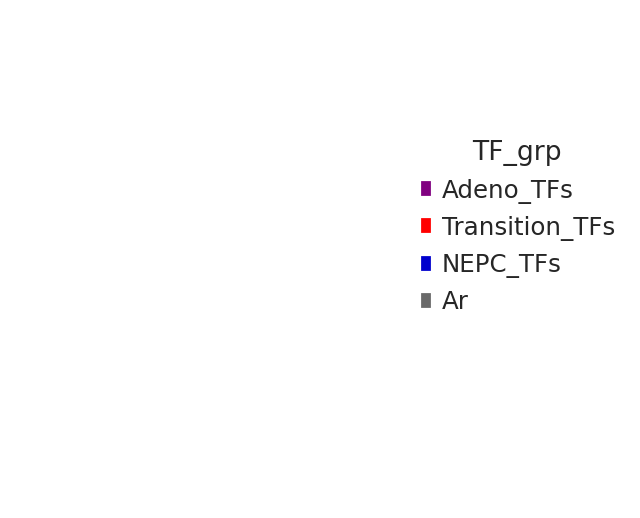

In [115]:
plt.rcParams['svg.fonttype']='none'
handles = [Patch(facecolor=row_colormap[name]) for name in row_colormap]
legend=plt.legend(handles, row_colormap, title='TF_grp',frameon=False,
           bbox_to_anchor=(1.15, .75), bbox_transform=plt.gcf().transFigure)
plt.axis('off')
plt.show()

#### Differential expression of TFs across pseudotime modules

In [116]:
# define cell-based modules here...
# get scaled gene-gene correlation matrix
X = np.array(smooth_df)
z = zscore(X.T,axis=1)

k=3
dist_metric='euclidean'
linkages='ward'
agg_clustering = AgglomerativeClustering(n_clusters=k,affinity = dist_metric,linkage=linkages).fit(z.T)
cell_labels = agg_clustering.labels_

cell_modules = pd.DataFrame(cell_labels,index=smooth_df.index)

relabel_d = {
    0:2,
    1:0,
    2:1,
}
cell_modules[0] = [relabel_d[x] for x in cell_modules[0]]

/home/tnoel/anaconda3/envs/myenv_39/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [117]:
# categorize pseudotime into 3 bins
tf_ad = ep_ad.copy()#[:,genes.index.tolist()].copy()
tf_ad.obs['pseudotime_modules'] = cell_modules[0]

In [118]:
tf_ad.uns['log1p']['base']=None

In [120]:
tf_ad.obs['pseudotime_modules'] = tf_ad.obs['pseudotime_modules'].astype('category')
sc.tl.rank_genes_groups(tf_ad,groupby='pseudotime_modules',pts=True,use_raw=False)

tf_de_pseudobin = sc.get.rank_genes_groups_df(tf_ad,group=None)
tf_de_pseudobin = tf_de_pseudobin.query("pvals_adj < .05 and logfoldchanges > 0.").copy()
tfs = genes.index.tolist()
tf_de_pseudobin = tf_de_pseudobin.query("names == @tfs").copy()

tf_module_d = dict(zip(tf_modules_df.tf, tf_modules_df.module))
tf_de_pseudobin['module'] = [tf_module_d[x] for x in tf_de_pseudobin['names']]

/home/tnoel/anaconda3/envs/myenv_39/lib/python3.9/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


In [129]:
sig_tfs = tf_de_pseudobin.query("group=='1' and module==1").names.tolist()+tf_de_pseudobin.query("group=='0' and module==0").names.tolist()+tf_de_pseudobin.query("group=='2' and module==2").names.tolist()

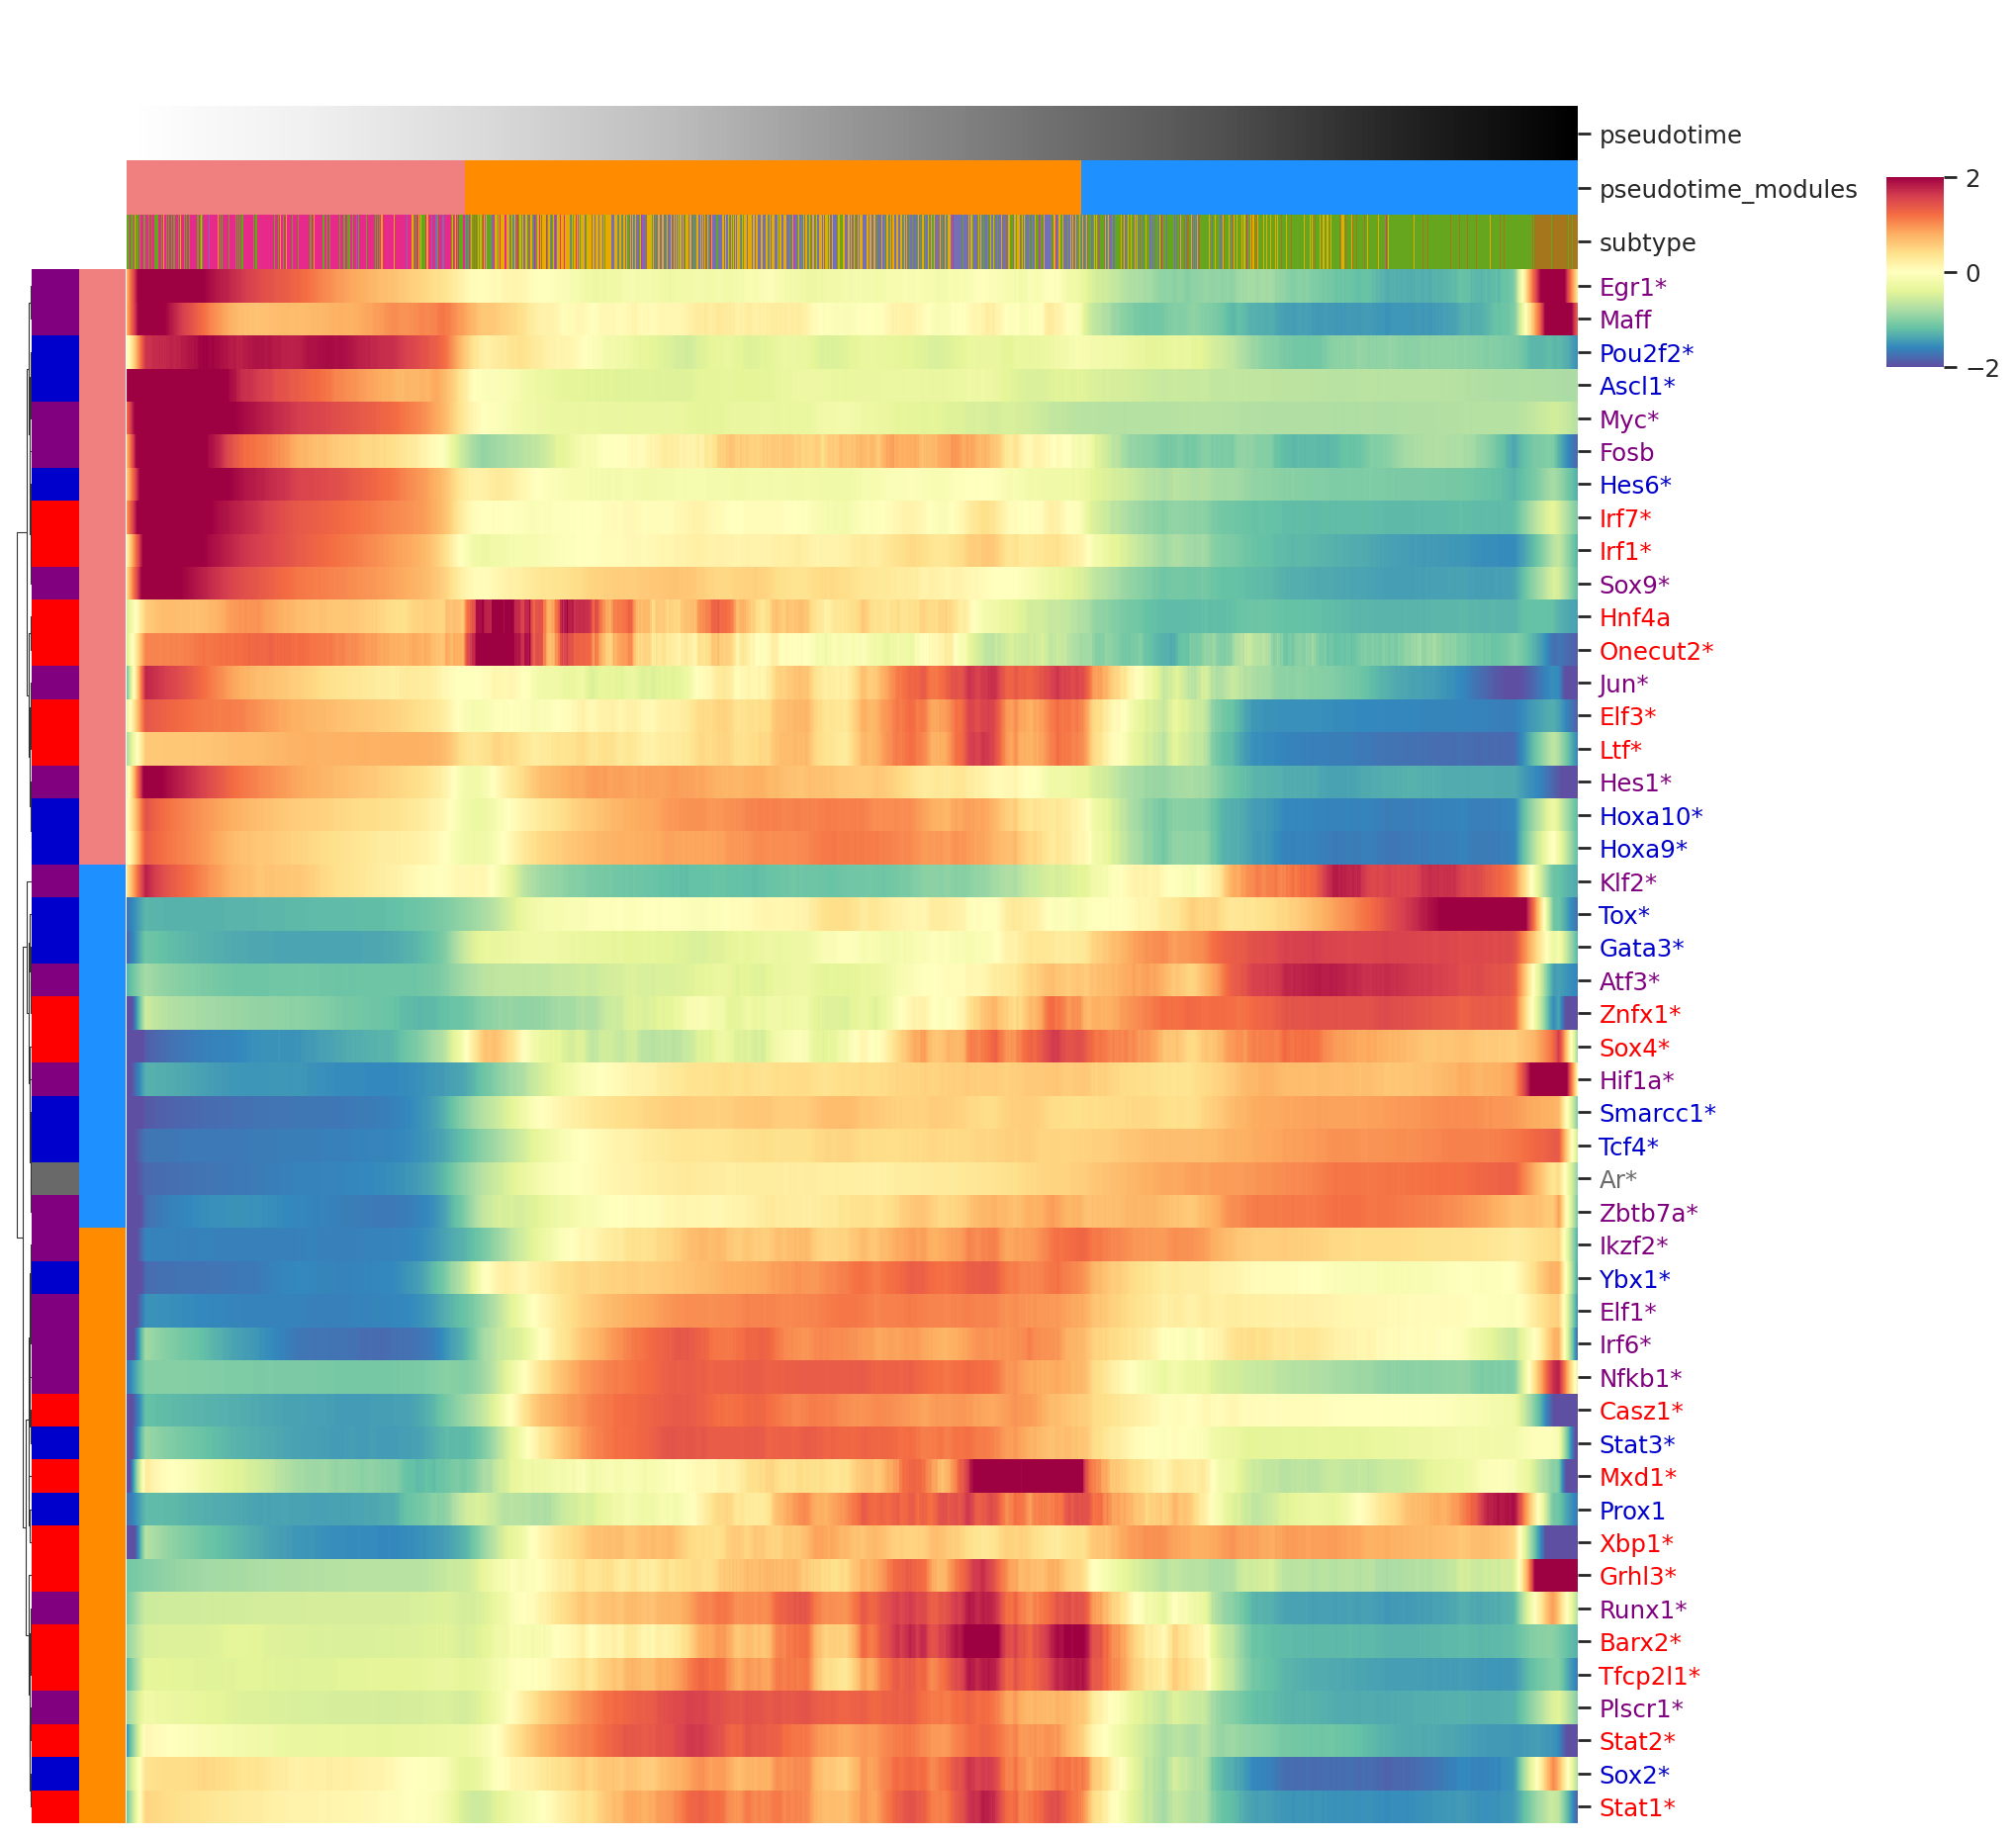

In [132]:
ep_ad.obs['pseudotime_modules'] = cell_modules[0]
tf_modules = pd.DataFrame(np.vstack([smooth_df.T.index,labels]).T,columns=['tf','module']).set_index('tf')
tf_modules = tf_modules['module']

row_colormap = {
    'Adeno_TFs':'purple',
    'Transition_TFs':'red',
    'NEPC_TFs':'mediumblue',
    'Ar':'dimgrey'
}
row_colors = grps.map(row_colormap)

col_colormap = {}
clusters = ep_ad.obs['subtype']
for i,cluster in enumerate(np.unique(clusters)):
    col_colormap[cluster] = sns.color_palette('Dark2_r').as_hex()[i]
col_colors = clusters.map(col_colormap)

row_colormap2 = {
    0:'lightcoral',
    1:'darkorange',
    2:'dodgerblue',
    3:'red'
}
row_colors2 = tf_modules.map(row_colormap2)

col_colormap2 = {}
clusters = ep_ad.obs['pseudotime_modules']
col_colormap2 = {
    0:'lightcoral',
    1:'darkorange',
    2:'dodgerblue'
}
col_colors2 = clusters.map(col_colormap2)
col_color_df= pd.DataFrame([col_colors,col_colors2]).T

n_cells = ep_ad.n_obs
pt_ordered = ep_ad.obs.sort_values(by='pseudotime')[['pseudotime_modules']]
pt_ordered['pseudotime'] = list(sns.color_palette('Greys',n_cells).as_hex())
col_color_df['pseudotime'] = pt_ordered['pseudotime']

plt.rcParams['svg.fonttype'] = 'none'
smooth_df.columns = ['{}*'.format(x) if x in sig_tfs else x for x in smooth_df.columns]
g=sns.clustermap(smooth_df.T,col_cluster=False,row_cluster=True,metric='euclidean',method='ward',vmax=2,vmin=-2,z_score=0,
               dendrogram_ratio=(.01,.05),figsize=(12,12),yticklabels=True,cmap='Spectral_r',col_colors=col_color_df[['pseudotime','pseudotime_modules','subtype']],row_colors=[row_colors,row_colors2],xticklabels=False)
ax = g.ax_heatmap
g.ax_cbar.set_position((1., .8, .03, .1))
ax.set_xlabel('')
ax.set_ylabel('')

for tick_label in g.ax_heatmap.axes.get_yticklabels():
    tick_text = tick_label.get_text().replace('*','')
    gene_name = grps.loc[tick_text]
    tick_label.set_color(row_colormap[gene_name])
plt.savefig('./tf_across_pseudotime_heatmap.svg',format='svg',dpi=300,bbox_inches='tight')
plt.show()

/tmp/ipykernel_63830/2354484332.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(cell_module_pt_med,x='cell_module',y='median_pseudotime',palette='Greys')


<Axes: xlabel='cell_module', ylabel='median_pseudotime'>

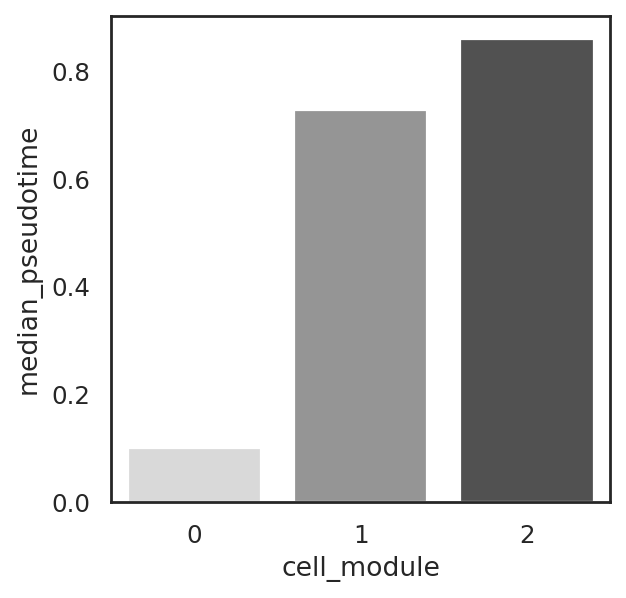

In [133]:
cell_module_pt_med = []
for cell_module in np.unique(ep_ad.obs['pseudotime_modules']):
    cell_module_meta = ep_ad.obs.query("pseudotime_modules==@cell_module").copy()
    pt_med = np.quantile(cell_module_meta['pseudotime'],.5)
    cell_module_pt_med.append([cell_module,pt_med])
cell_module_pt_med = pd.DataFrame(cell_module_pt_med,columns=['cell_module','median_pseudotime'])
sns.barplot(cell_module_pt_med,x='cell_module',y='median_pseudotime',palette='Greys')

In [134]:
pct_cm_per_subtype = []
for subtype in np.unique(ep_ad.obs['subtype']):
    subtype_meta = ep_ad.obs[ep_ad.obs['subtype']==subtype].copy()
    n_subtype = subtype_meta.shape[0]
    for cell_module in np.unique(ep_ad.obs['pseudotime_modules']):
        cell_module_meta = subtype_meta.query("pseudotime_modules==@cell_module").copy()
        n_cell_module = cell_module_meta.shape[0]
        pct_cm_per_subtype.append([subtype,cell_module,n_cell_module/n_subtype*100])
pct_cm_per_subtype = pd.DataFrame(pct_cm_per_subtype,columns=['subtype','cell_module','pct'])

Text(0.5, 81.696, '')

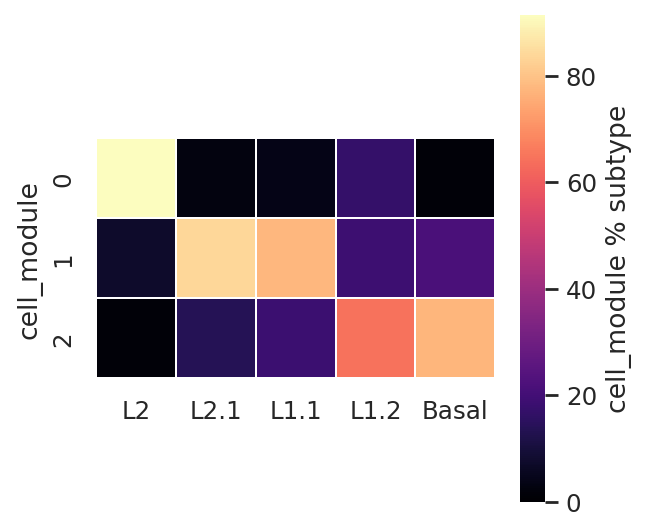

In [135]:
mtx = pct_cm_per_subtype.pivot(index='subtype',columns='cell_module',values='pct')
ax = sns.heatmap(mtx.T[['L2','L2.1','L1.1','L1.2','Basal']],cmap='magma',square=True,linewidth=.005,cbar_kws={'label': 'cell_module % subtype'},vmin=0)
ax.set_xlabel('')

In [136]:
# figure out umaps and dataframe to save below...

In [137]:
ep_ad.uns['log1p']['base'] = None

In [140]:
tf_modules_df = pd.DataFrame(np.vstack([smooth_df.T.index,labels]).T,columns=['tf','module'])
tf_modules_df['module'] = tf_modules_df['module'].astype(str)
all_de_tfs = [x for x in tf_modules_df['tf'] if '*' in x]

In [141]:
len(all_de_tfs)

43

In [142]:
sig_tf_modules = tf_modules_df.query("tf in @all_de_tfs")
sig_tf_grps = []
for tf in sig_tf_modules['tf'].tolist():
    for key in tf_d.keys():
        if tf.replace('*','') in tf_d[key]:
            sig_tf_grps.append(key)
    if tf.replace('*','') == 'Ar':
        sig_tf_grps.append(np.nan)
sig_tf_modules['tf_grp'] = sig_tf_grps

/tmp/ipykernel_63830/1488356310.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_tf_modules['tf_grp'] = sig_tf_grps


In [143]:
#sig_tf_modules.to_csv('./sig_tf_modules.csv')

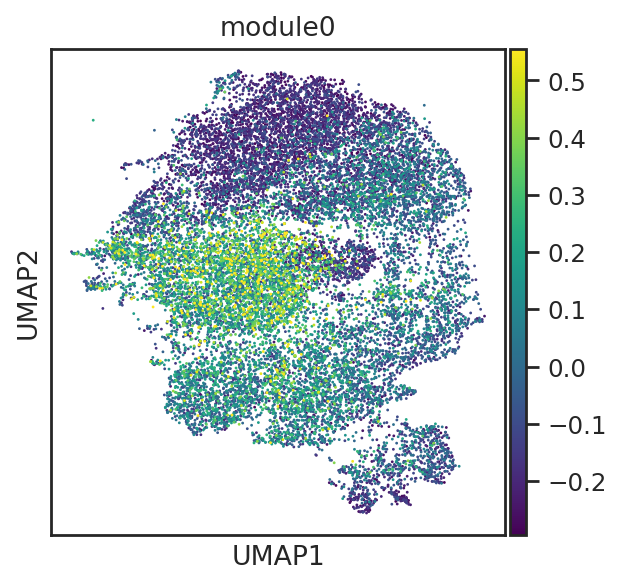

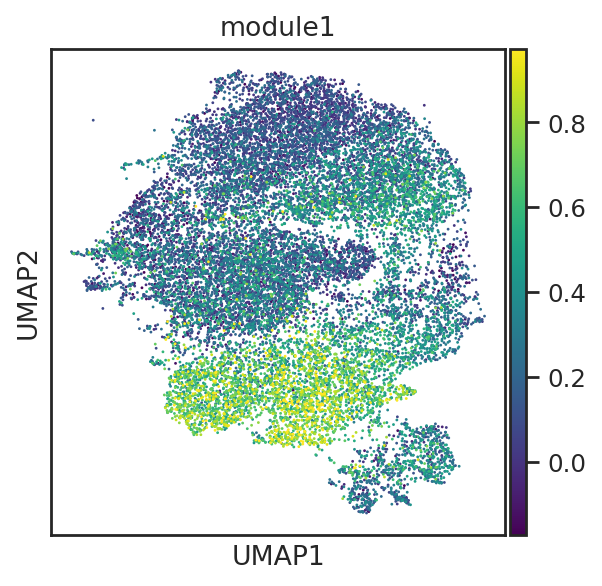

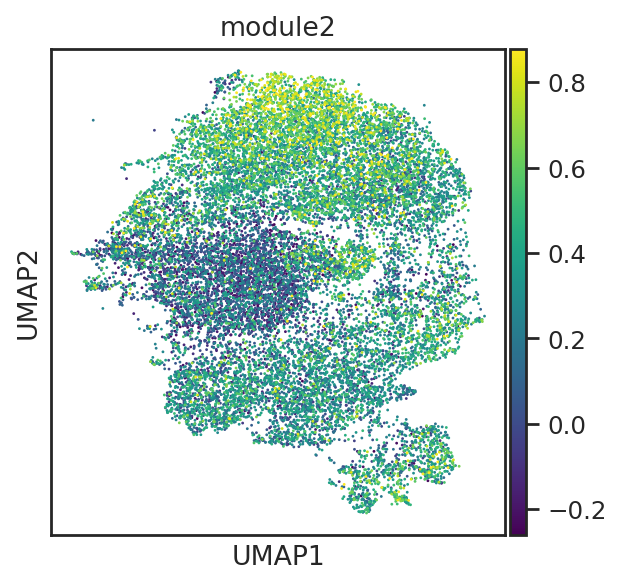

In [144]:
for module in range(3):
    module_str = str(module)
    sc.tl.score_genes(ep_ad,[x.replace('*','') for x in sig_tf_modules.query("module==@module_str")['tf'].tolist()],use_raw=False)
    vmax = np.quantile(ep_ad.obs['score'],.99)
    vmin = np.quantile(ep_ad.obs['score'],.01)
    sc.pl.umap(ep_ad,color='score',cmap='viridis',title='module{}'.format(str(module)),vmin=vmin,vmax=vmax,save='_module{}'.format(str(module)))
    plt.show()